# LANL Host Dataset

### Article : https://www.worldscientific.com/doi/pdf/10.1142/9781786345646_001

Notes:

"The events from the host logs included in the data set are all related to authentication and process activity on each machine"

### Pour obtenir le dataset:
1- https://csr.lanl.gov/data/2017/#citing : donner mail, obtenir le lien

2- https://csr.lanl.gov/data-fence/... 10 chiffres.../... token... iXYXXbqw15UugRnZALCZ2Y8dvEk=... /unified-host-network-dataset-2017/wls.html pour avoir l'index avec tous les fichiers compressés

3- download : for i in $(seq -w 1 90); do wget -c https://csr.lanl.gov/data-fence/...10 chiffres.../...token.../unified-host-network-dataset-2017/wls/wls_day-$i.bz2; done

4- decompress, as required : bzip2 -dk filename.bz2

### EventID : 

EventID         Description

Authentication events

4768            Kerberos authentication ticket was requested (TGT)

4769            Kerberos service ticket was requested (TGS)

4770            Kerberos service ticket was renewed

4774            An account was mapped for logon

4776            Domain controller attempted to validate credentials

4624            An account successfully logged on, see Logon Types

4625            An account failed to logon, see Logon Types

4634            An account was logged off, see Logon Types

4647            User initiated logoff

4648            A logon was attempted using explicit credentials

4672            Special privileges assigned to a new logon

4800            The workstation was locked

4801            The workstation was unlocked

4802            The screensaver was invoked

4803            The screensaver was dismissed

Process events

4688            Process start

4689            Process end

System events

4608            Windows is starting up

4609            Windows is shutting down

1100            Event logging service has shut down (often recorded instead of EventID 4609)


Detailed description : - EventID : https://learn.microsoft.com/en-us/windows-server/identity/ad-ds/plan/appendix-l--events-to-monitor


### Logon Types for EventIDs: 4624, 4625 and 4634

LogonTypes (EventIDs: 4624, 4625 and 4634)

2 — Interactive

3 — Network

4 — Batch

12 — Cached Remote-Interactive

5 — Service

9 — New Credentials

7 — Unlock

10 — Remote Interactive

8 — Network Clear Text 11 — Cached Interactive

0 — Used only by the system account

### Host Log Fields

. Time: The epoch time of the event in seconds.

• EventID: Four digit integer corresponding to the event id of the record.

• LogHost: The hostname of the computer that the event was recorded on.In the case of directed authentication events, the LogHost will correspond to the computer that the authentication event is terminating at (destination computer).

• LogonType: Integer corresponding to the type of logon, see Table 2.

• LogonTypeDescription: Description of the LogonType, see Table 2.

• UserName: The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.

• DomainName: Domain name of UserName.

• LogonID: A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.

• SubjectUserName: For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.

• SubjectDomainName: Domain name of SubjectUserName.

• SubjectLogonID: See LogonID.

• Status: Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f

• Source: For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.

• ServiceName: The account name of the computer or service the user is requesting the ticket for.

• Destination: This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.

• AuthenticationPackage: The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.

• FailureReason: The reason for a failed logon.

• ProcessName: The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).

• ProcessID: A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.

• ParentProcessName: The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.

• ParentProcessID: Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.

In [1]:
import json
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# lit le fichier de 12+ Gb ligne par ligne

dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-01.json'

filepath = dirpath + filename

In [3]:
# lit les N_SAMPLES premières lignes du fichier wls_day-01.json décompressé

N_SAMPLES = 10
with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        line = f.readline()
        # print(line)
        # print(json.dumps(line, sort_keys=True, indent=4))
        obj_json = json.loads(line)
        print(obj_json)

{'UserName': 'Comp607982$', 'EventID': 4688, 'LogHost': 'Comp607982', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2ac', 'ProcessName': 'svchost.exe', 'Time': 1, 'ProcessID': '0x1418'}
{'UserName': 'Comp991643$', 'EventID': 4688, 'LogHost': 'Comp991643', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x334', 'ProcessName': 'rundll32.exe', 'Time': 1, 'ProcessID': '0xc0c'}
{'UserName': 'Comp736087$', 'EventID': 4688, 'LogHost': 'Comp736087', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2e8', 'ProcessName': 'svchost.exe', 'Time': 1, 'ProcessID': '0x2074'}
{'UserName': 'Comp093128$', 'EventID': 4688, 'LogHost': 'Comp093128', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2d4', 'ProcessName': 'vssvc.exe', 'Time': 1, 'ProcessID': '0x2200'}
{'UserName': 'Comp006850$', 'Event

In [4]:
# on va regarder les EventIDs qui correspondent aux évènements d'authentification

authentication_events = {
    4768 : 'Kerberos authentication ticket was requested (TGT)',
    4769 : 'Kerberos service ticket was requested (TGS)',
    4770 : 'Kerberos service ticket was renewed',
    4774 : 'An account was mapped for logon',
    4776 : 'Domain controller attempted to validate credentials',
    4624 : 'An account successfully logged on, see Logon Types',
    4625 : 'An account failed to logon, see Logon Types',
    4634 : 'An account was logged off, see Logon Types',
    4647 : 'User initiated logoff',
    4648 : 'A logon was attempted using explicit credentials',
    4672 : 'Special privileges assigned to a new logon',
    4800 : 'The workstation was locked',
    4801 : 'The workstation was unlocked',
    4802 : 'The screensaver was invoked',
    4803 : 'The screensaver was dismissed'
}

liste_authentication_events = list(authentication_events.keys())

In [5]:
# combien d'EventIDs correspondant à un évènement d'authentification ? Environ 57% de tous les évènements

total = 0
auth = 0

N_SAMPLES = 1000

with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        line = f.readline()
        obj_json = json.loads(line)
        if obj_json.get('EventID') in liste_authentication_events:
            auth += 1
        total += 1
        print(f'{total} lignes traitées', end='\r', flush=True)

print()
print(f'{total} evènements, dont {auth} pour authentification ({auth/total*100:.2f}%)')

1000 lignes traitées
1000 evènements, dont 570 pour authentification (57.00%)


In [6]:
# Extrait les évènements d'authentification : host event logs capture with authentication eventIDs
# et écrit des fichiers avec des tailles différentes (N samples d'authentification)

N_AUTHENTIFICATION_SAMPLES = [10, 100, 1000, 10000, 100000, 1000000]

#-- fichier json complet ---
dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-01.json'
filepath = dirpath + filename

presents = os.listdir(dirpath)

In [7]:
#-- boucle extraction --
for n_authentication_samples in N_AUTHENTIFICATION_SAMPLES:
    subset_filename = 'wls_day-01_subset_' + f'{n_authentication_samples}' + '.json'  # fichier dans lequel on va écrire les lignes avec EventID d'authentification
    if subset_filename in presents:
        print(f'{subset_filename} déjà présent')
    else:
        print(f'extrait {subset_filename}')
        subset_filepath = dirpath + subset_filename
        ctr = 0  # compteur d'évènements d'authentification
        print("\n" + f"Extrait fichier de {n_authentication_samples} évènements d'auhentification")
        with open(filepath, 'r') as f:
            while ctr < n_authentication_samples:
                    line = f.readline()
                    obj_json = json.loads(line)
                    if obj_json.get('EventID') in liste_authentication_events:
                        ctr += 1
                        print(f'{ctr} évènements extraits', end='\r', flush=True)
                        with open(subset_filepath, 'a') as g:
                            g.write(line)

wls_day-01_subset_10.json déjà présent
wls_day-01_subset_100.json déjà présent
wls_day-01_subset_1000.json déjà présent
wls_day-01_subset_10000.json déjà présent
wls_day-01_subset_100000.json déjà présent
wls_day-01_subset_1000000.json déjà présent


# EDA

In [8]:
def get_df_from_file(n_eda=1000, dirpath='/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'):
    """Utility function to get a wls** file and return a DataFrame

    Args:
        n_eda (int, optional): file index. Defaults to 1000.
    """
    
    filename = 'wls_day-01_subset_' + f'{n_eda}' + '.json'

    subset_filepath = dirpath + filename
    print(f'Charge {filename} et créée une DataFrame')
    df = pd.read_json(subset_filepath, lines=True)
    
    return df   

In [9]:
N_EDA = [1000]  # liste de suffixes pour les fichiers à traiter

for n_eda in N_EDA:
    df = get_df_from_file(n_eda=n_eda)

Charge wls_day-01_subset_1000.json et créée une DataFrame


In [10]:
df

,UserName,EventID,LogHost,LogonID,DomainName,LogonTypeDescription,ProcessName,AuthenticationPackage,Time,LogonType,ProcessID,Source,Destination,SubjectUserName,SubjectLogonID,SubjectDomainName,Status,ServiceName,FailureReason
0,system,4624,Comp828729,0x3e7,nt authority,Service,services.exe,Negotiate,1,5.0,0x29c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,system,4672,Comp828729,0x3e7,nt authority,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,system,4672,Comp423597,0x3e7,nt authority,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,system,4624,Comp050550,0x3e7,nt authority,Service,services.exe,Negotiate,1,5.0,0x2ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comp939275$,4624,Comp661433,0x23a8696,Domain001,Network,NaN,Kerberos,1,3.0,NaN,Comp939275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,AppService,4624,EnterpriseAppServer,0x8ce906a,Domain001,Network,Proc746489.exe,Kerberos,1,3.0,0x17e0,EnterpriseAppServer,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,system,4624,Comp677555,0x3e7,nt authority,Service,services.exe,Negotiate,1,5.0,0x2fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,AppService,4672,EnterpriseAppServer,0x8ce906a,Domain001,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,AppService,4634,EnterpriseAppServer,0x8ce906a,Domain001,Network,NaN,NaN,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recherche des NaN

In [11]:
# display %ages of NaN values

df.isna().sum(axis=0).sort_values(ascending=False)/len(df)*100

# NB : 
# 1- Failure Reason is described only when EventID = 4625 (failed logon)
# 2- Destination : need expert view here
# 3- Subject XX : maps to XX ?
# 4- ServiceName : service name user is requesting access for (=additional info)
# 5- ProcessName : process that originated the authentication event
# 6- ProcessID : semi-unique process ID
# 7- Status : status of the request - correlates with code 4625 ?
# 8- Source : source computer, correlates with LogHost
# 9- Authentication Package : type of authentication
# 10- Logon XXs : type and ID of Logons

FailureReason            99.9
SubjectDomainName        98.9
SubjectLogonID           98.9
SubjectUserName          98.9
Destination              98.9
ServiceName              97.8
Status                   91.0
Source                   86.4
ProcessID                59.0
ProcessName              59.0
LogonType                51.9
LogonTypeDescription     51.9
AuthenticationPackage    50.7
LogonID                   9.0
EventID                   0.0
Time                      0.0
DomainName                0.0
LogHost                   0.0
UserName                  0.0
dtype: float64

In [12]:
# regarde quelles sont les lignes avec FailureReason != NaN : ce sont les EventIDs = 4625 (logon failed)

# df[df['FailureReason'].isna() == False].describe(include='all').transpose()

In [13]:
columns_without_nan = ['UserName', 'EventID', 'LogHost', 'DomainName','Time']

columns_to_drop = [ c for c in df.columns if c not in columns_without_nan ]

In [14]:
# On drope violemment les colonnes avec NaN

df.drop(columns=columns_to_drop,inplace=True)

### Post Processing

In [15]:
#1 créé un user name unique en aggrégeant le UserName et le DomainName

df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']

### Nettoyage

In [16]:
# Nettoyage :
# 1- Une simple PCA montre que les LogonIDs expliquent 99% de la variance : on les retire

# df.drop(columns=['LogonID'], inplace=True)

### Stats générales

In [17]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,1000,28,system,774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EventID,1000.0,NaN,NaN,NaN,4658.109,42.485953,4624.0,4624.0,4672.0,4672.0,4776.0
LogHost,1000,395,ActiveDirectory,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DomainName,1000,2,nt authority,774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,1000.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
UserNameAndDomainName,1000,28,system_nt authority,774,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   UserName               1000 non-null   object
 1   EventID                1000 non-null   int64 
 2   LogHost                1000 non-null   object
 3   DomainName             1000 non-null   object
 4   Time                   1000 non-null   int64 
 5   UserNameAndDomainName  1000 non-null   object
dtypes: int64(2), object(4)
memory usage: 47.0+ KB


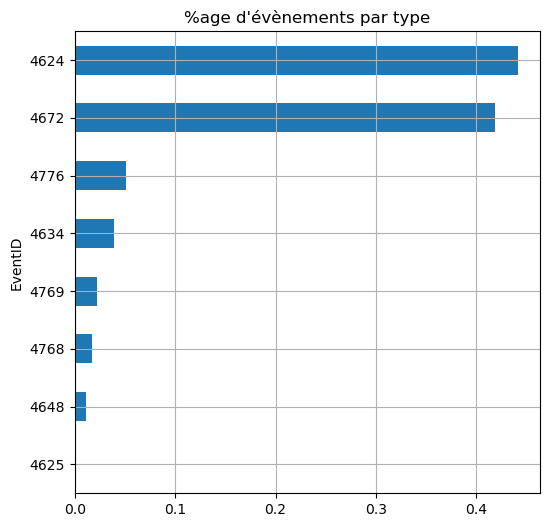

In [19]:
fig, ax = plt.subplots(figsize=(6,6))

eventid_counts = df['EventID'].value_counts() / df['EventID'].value_counts().sum()

ax = eventid_counts.plot(kind='barh')
ax.set_title("%age d'évènements par type")
ax.invert_yaxis()
ax.grid(True)
plt.show()

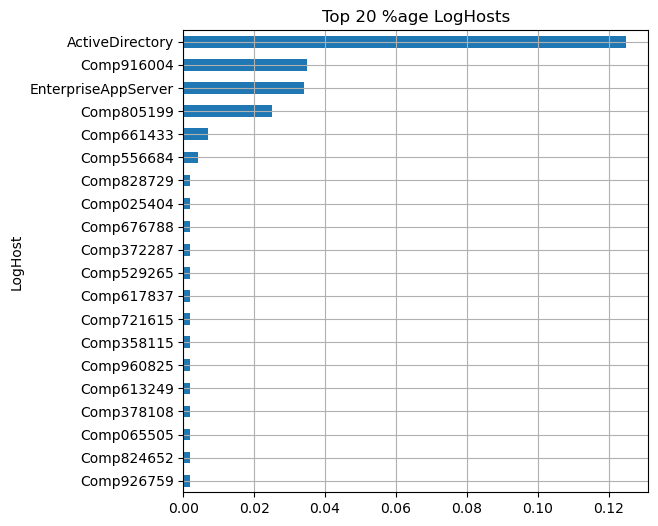

In [20]:
MAX_LOGHOSTS = 20

fig, ax = plt.subplots(figsize=(6,6))

loghost_counts = df['LogHost'].value_counts() / df['LogHost'].value_counts().sum()
ax = loghost_counts[:MAX_LOGHOSTS].plot(kind='barh')
ax.set_title(f"Top {MAX_LOGHOSTS} %age LogHosts")
ax.invert_yaxis()
ax.grid(True)
plt.show()

In [21]:
# MAX_LOGONIDS = 20

# fig, ax = plt.subplots(figsize=(6,6))

# logonids_counts = df['LogonID'].value_counts() / df['LogonID'].value_counts().sum()
# ax = logonids_counts[:MAX_LOGONIDS].plot(kind='barh')
# ax.set_title(f"Top {MAX_LOGONIDS} %age LogonIDs")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

In [22]:
# MAX_LOGONTYPES = 20

# fig, ax = plt.subplots(figsize=(6,6))

# logontype_counts = df['LogonTypeDescription'].value_counts() / df['LogonTypeDescription'].value_counts().sum()
# ax = logontype_counts[:MAX_LOGONTYPES].plot(kind='barh')
# ax.set_title(f"Top {MAX_LOGONTYPES} %age LogonTypes")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

In [23]:
# MAX_PROCESSNAMES = 20

# fig, ax = plt.subplots(figsize=(6,6))

# processname_counts = df['ProcessName'].value_counts() / df['ProcessName'].value_counts().sum()
# ax = processname_counts[:MAX_PROCESSNAMES].plot(kind='barh')
# ax.set_title(f"Top {MAX_PROCESSNAMES} %age ProcessNames")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

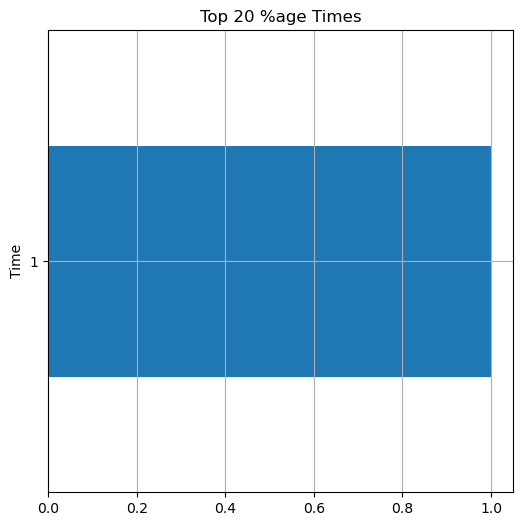

In [24]:
MAX_TIMES = 20

fig, ax = plt.subplots(figsize=(6,6))

times_counts = df['Time'].value_counts() / df['Time'].value_counts().sum()
ax = times_counts[:MAX_TIMES].plot(kind='barh')
ax.set_title(f"Top {MAX_TIMES} %age Times")
ax.invert_yaxis()
ax.grid(True)
plt.show()

In [25]:
# MAX_FAILURE_REASONS = 20

# fig, ax = plt.subplots(figsize=(6,6))

# fr_counts = df['FailureReason'].value_counts() / df['FailureReason'].value_counts().sum()
# ax = fr_counts[:MAX_FAILURE_REASONS].plot(kind='barh')
# ax.set_title(f"Top {MAX_FAILURE_REASONS} %age Failure Reason")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

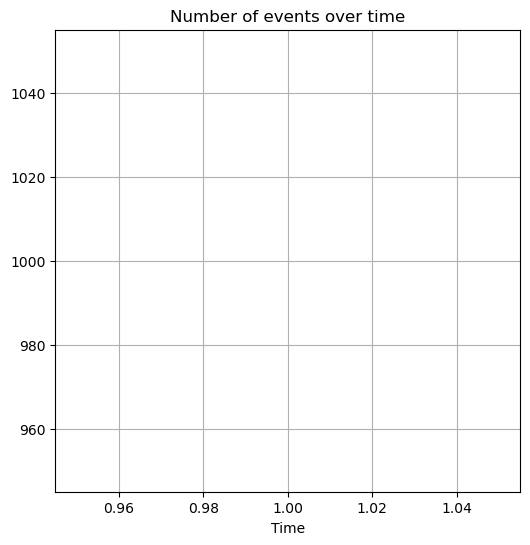

In [26]:
fig, ax = plt.subplots(figsize=(6,6))

ax = df['Time'].value_counts(sort=False).plot()
ax.set_title('Number of events over time')
ax.grid(True)

# Get a DataFrame from one record and transform it into categorical data

In [27]:
N = 10000 #index of the file to process, number of samples

In [28]:
df = get_df_from_file(n_eda=N)

Charge wls_day-01_subset_10000.json et créée une DataFrame


In [29]:
# Nettoyage

df.drop(columns=columns_to_drop, inplace=True)

In [30]:
df

,UserName,EventID,LogHost,DomainName,Time
0,system,4624,Comp828729,nt authority,1
1,system,4672,Comp828729,nt authority,1
2,system,4672,Comp423597,nt authority,1
3,system,4624,Comp050550,nt authority,1
4,Comp939275$,4624,Comp661433,Domain001,1
...,...,...,...,...,...
9995,system,4624,Comp213123,nt authority,2
9996,system,4672,Comp213123,nt authority,2
9997,AppService,4634,EnterpriseAppServer,Domain001,2
9998,AppService,4648,EnterpriseAppServer,Domain001,2


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserName    10000 non-null  object
 1   EventID     10000 non-null  int64 
 2   LogHost     10000 non-null  object
 3   DomainName  10000 non-null  object
 4   Time        10000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


In [32]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,10000,102,system,8799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EventID,10000.0,NaN,NaN,NaN,4651.064,31.774085,4624.0,4624.0,4648.0,4672.0,4776.0
LogHost,10000,2729,ActiveDirectory,472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DomainName,10000,4,nt authority,8805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,10000.0,NaN,NaN,NaN,1.497,0.500016,1.0,1.0,1.0,2.0,2.0


### Traitement des données

In [33]:
def process_df_into_cat(df=df):
    """Process DataFrame from wls into a DataFrame with integer-based categorical values, 
    except time, that remains as is.

    Args:
        df (_type_, optional): Dataframe issued from a wls file. Defaults to df.
    """
    
    # create a unique identifier for the user
    df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']
    
    # manages all columns except Time
    columns = list(df.columns)
    columns.remove('Time')
    for c in columns:
        c_new = c + '_code'
        df[c_new] = df[c].astype("category").cat.codes
        
    df.drop(columns=columns, inplace=True)
    return df

In [34]:
df = process_df_into_cat(df=df)

In [35]:
df

,Time,UserName_code,EventID_code,LogHost_code,DomainName_code,UserNameAndDomainName_code
0,1,101,0,2217,3,103
1,1,101,4,2217,3,103
2,1,101,4,1110,3,103
3,1,101,0,152,3,103
4,1,51,0,1730,1,52
...,...,...,...,...,...,...
9995,2,101,0,562,3,103
9996,2,101,4,562,3,103
9997,2,3,2,2728,1,4
9998,2,3,3,2728,1,4


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Time                        10000 non-null  int64
 1   UserName_code               10000 non-null  int8 
 2   EventID_code                10000 non-null  int8 
 3   LogHost_code                10000 non-null  int16
 4   DomainName_code             10000 non-null  int8 
 5   UserNameAndDomainName_code  10000 non-null  int8 
dtypes: int16(1), int64(1), int8(4)
memory usage: 136.8 KB


In [37]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,10000.0,1.4970,0.500016,1.0,1.00,1.0,2.0,2.0
UserName_code,10000.0,93.5455,23.497518,0.0,101.00,101.0,101.0,101.0
EventID_code,10000.0,2.1105,2.084400,0.0,0.00,3.0,4.0,7.0
LogHost_code,10000.0,1355.0726,860.759902,0.0,590.75,1359.0,2121.0,2728.0
DomainName_code,10000.0,2.7593,0.655749,0.0,3.00,3.0,3.0,3.0
UserNameAndDomainName_code,10000.0,95.4619,23.767500,0.0,103.00,103.0,103.0,103.0


# PCA - baseline

In [77]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

### 2D

In [39]:
pca2d = PCA(n_components=2)
pca2d.fit(df)

PCA(n_components=2)

In [40]:
pca2d.explained_variance_ratio_

array([0.99850496, 0.00148879])

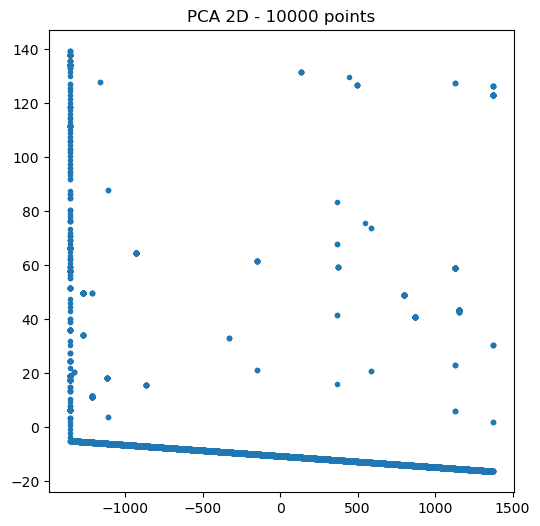

In [41]:
X_red2d = pca2d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(X_red2d[:,0], X_red2d[:,1], marker='.')
ax.set_title(f'PCA 2D - {N} points')
plt.show()

### 3D

In [42]:
pca = PCA(n_components=3)
pca.fit(df)

PCA(n_components=3)

In [43]:
pca.explained_variance_ratio_

array([9.98504955e-01, 1.48878785e-03, 5.76485075e-06])

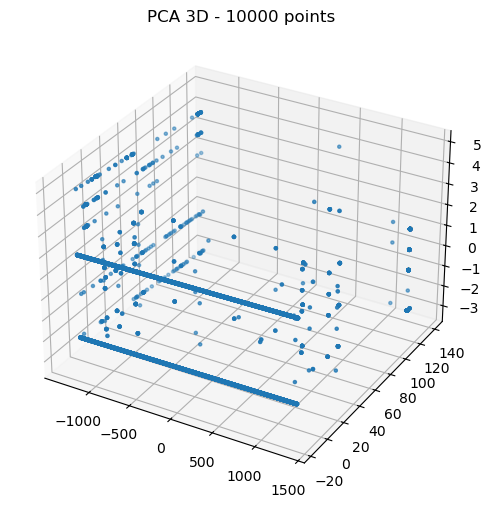

In [44]:
X_red = pca.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], marker='.')
ax.set_title(f'PCA 3D - {N} points')
plt.show()

### Un peu d'explications

In [45]:
def get_df_expl(pca, df=df):
    """return a Dataframe with explained variance ratio and decomposition of eigenvectors in pca model

    Args:
        pca (_type_): pca model, already fit
        df (_type_, optional): original dataframe. Defaults to df.
    """
    
    # to loop over number of components
    n_components = range(pca.n_components_)
    
    # build a dictionnary of n eigenvectors, each value is the list of coordinates in data space
    dict_eigenvectors = {
    n : list(pca.components_[n,:]) for n in n_components
}

    # build full dictionnary to pass to DF constructor
    dict = {
    'Explained_Variance_Ratio' : list(pca.explained_variance_ratio_),
}

    columns = list(df.columns)

    for i, c in enumerate(columns):
        dict[c] = [ dict_eigenvectors[j][i] for j in n_components]
        
    # build and return dataframe
    df_expl = pd.DataFrame.from_dict(data=dict)
    
    return df_expl

In [46]:
df_expl = get_df_expl(pca, df)

In [47]:
df_expl.transpose()

,0,1,2
Explained_Variance_Ratio,0.998505,0.001489,0.000006
Time,-0.000021,-0.001041,-0.006563
UserName_code,-0.002906,-0.702940,0.003284
EventID_code,-0.000224,0.005378,0.999734
LogHost_code,0.999991,-0.004132,0.000249
DomainName_code,0.000035,-0.016917,-0.021328
UserNameAndDomainName_code,-0.002941,-0.711014,0.004830


### Generalization to n eigenvectors > 3

In [48]:
N_COMPONENTS = 5

In [49]:
pca = PCA(n_components=N_COMPONENTS)
pca.fit(df)

PCA(n_components=5)

In [50]:
pca.explained_variance_ratio_

array([9.98504955e-01, 1.48878785e-03, 5.76485075e-06, 3.34972264e-07,
       1.49384447e-07])

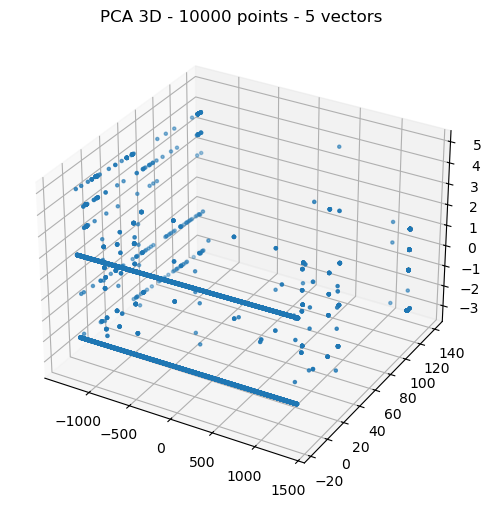

In [51]:
X_red = pca.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], marker='.')
ax.set_title(f'PCA 3D - {N} points - {N_COMPONENTS} vectors')
plt.show()

In [52]:
df_expl = get_df_expl(pca, df)

df_expl.transpose()

,0,1,2,3,4
Explained_Variance_Ratio,0.998505,0.001489,0.000006,3.349723e-07,1.493844e-07
Time,-0.000021,-0.001041,-0.006563,9.991219e-01,-4.104686e-02
UserName_code,-0.002906,-0.702940,0.003284,-4.520832e-03,-3.551259e-03
EventID_code,-0.000224,0.005378,0.999734,7.437235e-03,2.114561e-02
LogHost_code,0.999991,-0.004132,0.000249,1.415488e-05,-1.003414e-04
DomainName_code,0.000035,-0.016917,-0.021328,4.093148e-02,9.987263e-01
UserNameAndDomainName_code,-0.002941,-0.711014,0.004830,2.088992e-03,-2.003139e-02


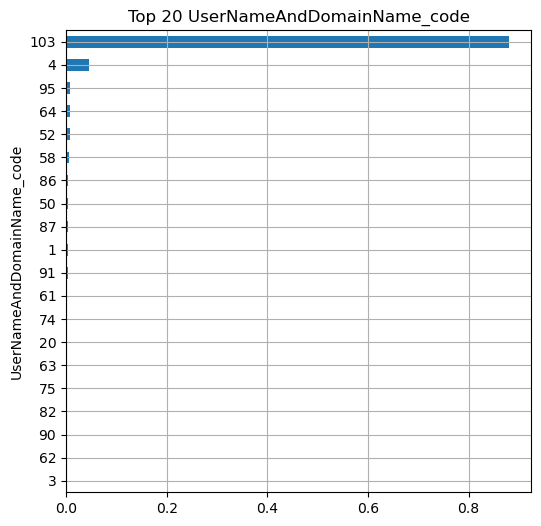

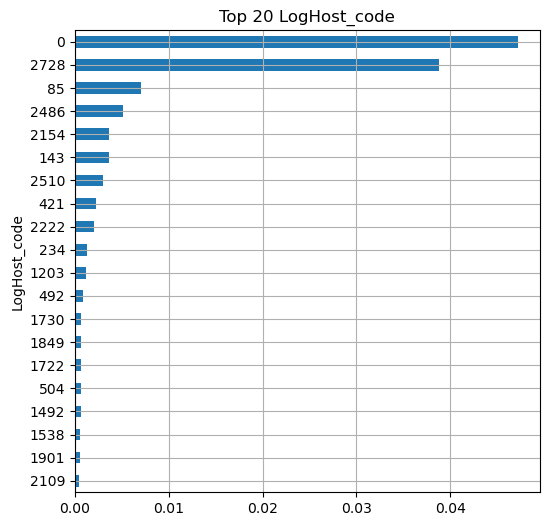

In [53]:
# regardons UserName_code, LogHost_code, Source_code

list_columns = ['UserNameAndDomainName_code', 'LogHost_code'] #, 'Source_code']
MAX_CAT = 20

for c in list_columns:
    fig, ax = plt.subplots(figsize=(6,6))

    counts = df[c].value_counts() / df[c].value_counts().sum()
    ax = counts[:MAX_CAT].plot(kind='barh')
    ax.set_title(f"Top {MAX_CAT} " + c)
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

### Kernel Density Estimation

In [54]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [55]:
# # grid search to find the best bandwith

# params = {"bandwidth" : np.logspace(0,1,3)}
# grid = GridSearchCV(KernelDensity(), params, cv=3,n_jobs=-1, verbose=3)
# grid.fit(df.to_numpy())

# print(f"Meilleur bandwidth : {grid.best_estimator_.bandwidth}")

# # utilise le meilleur estimateur

# kde = grid.best_estimator_

# ou bien, inéfrence directe

kde = KernelDensity(bandwidth=5.0).fit(df.to_numpy())


In [56]:
scores = [ kde.score(df.iloc[i].to_numpy().reshape(1,-1)) for i in range(len(df)) ]

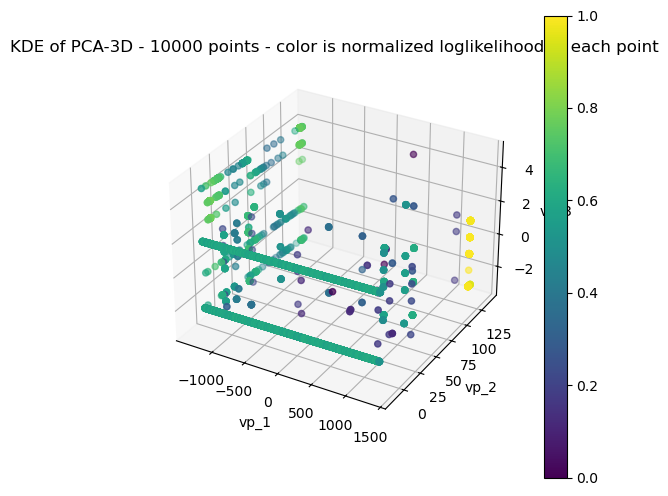

In [57]:
# 3D display of projected points on PCA manifold

X_red = PCA(n_components=3).fit_transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map values into color map
vmin = np.min(scores)
vmax = np.max(scores)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(scores)), marker='o') # 
ax.set_title(f'KDE of PCA-3D - {N} points - color is normalized loglikelihood of each point')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

### Gaussian Mixture Model

In [58]:
from sklearn.mixture import GaussianMixture

In [59]:
N_GAUSSIANS = 20

gm = GaussianMixture(n_components=N_GAUSSIANS, random_state=42, covariance_type='full', verbose=2)
gm.fit(df.to_numpy())

Initialization 0
Initialization converged: True	 time lapse 3.25910s	 ll 5.81070


GaussianMixture(n_components=20, random_state=42, verbose=2)

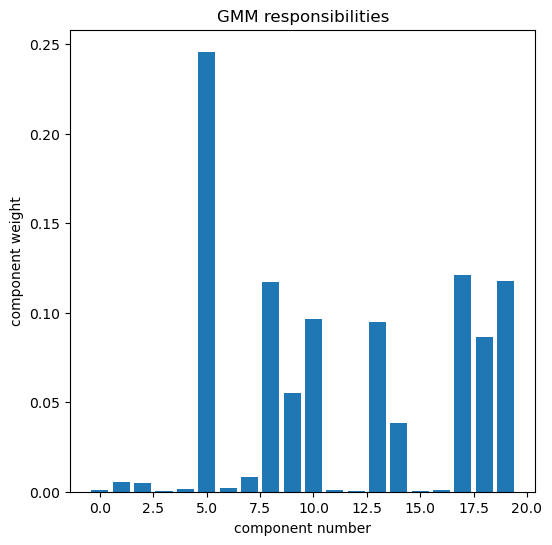

In [60]:
# responsibilities = list(gm.weights_)

# responsibilities.sort(reverse=True)

# print(responsibilities)

comp_number = [ x for x in range(N_GAUSSIANS) ]
responsibilities = list(gm.weights_)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(comp_number, responsibilities)
ax.set_xlabel('component number')
ax.set_ylabel('component weight')
ax.set_title(f'GMM responsibilities')
plt.show()

In [61]:
labels = gm.predict(df.to_numpy())

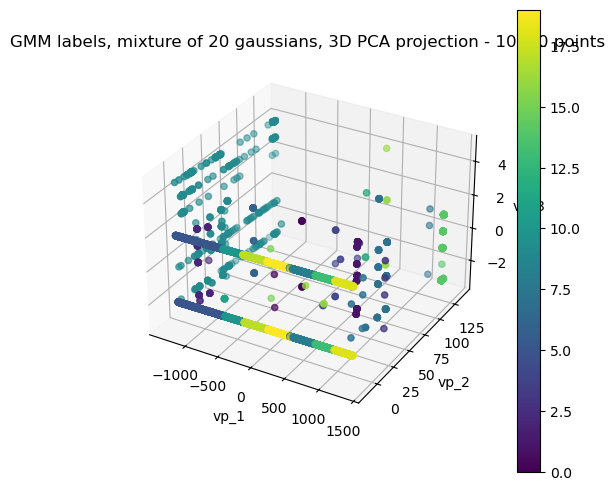

In [62]:
# 3D display of GMM - projected points on PCA manifold

X_red = PCA(n_components=3).fit_transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
# vmin = np.min(labels)
# vmax = np.max(labels)
# norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=labels, marker='o') # 
ax.set_title(f'GMM labels, mixture of {N_GAUSSIANS} gaussians, 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

In [63]:
# get responsibilities per point
probas = gm.predict_proba(df.to_numpy())

# get predicted label, and associated responsibility, per data point
labels = np.argmax(probas, axis=1)
certainty = np.max(probas, axis=1)

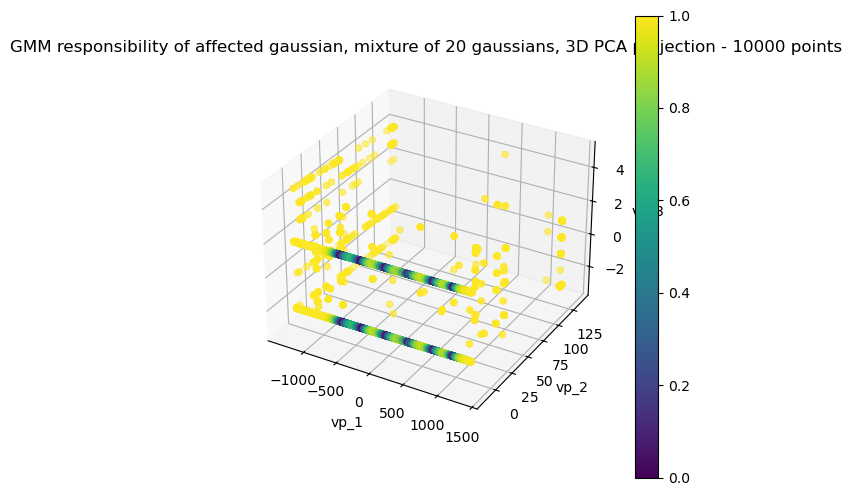

In [64]:
# 3D display of GMM - projected points on PCA manifold

X_red = PCA(n_components=3).fit_transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(certainty)
vmax = np.max(certainty)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(certainty)), marker='o') # 
ax.set_title(f'GMM responsibility of affected gaussian, mixture of {N_GAUSSIANS} gaussians, 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

### Variational Bayesian Gaussian Mixture

In [65]:
from sklearn.mixture import BayesianGaussianMixture

In [66]:
N_RESPONSIBILITIES_MAX = 100

In [67]:
dpbgm = BayesianGaussianMixture(
    n_components = N_RESPONSIBILITIES_MAX, # max number of components, will be infered by data
    weight_concentration_prior_type = 'dirichlet_process',   # weight concentration prior is Dirchlet process : (approximate) infinite number of components
    random_state = 42,
    verbose = 3
)

In [68]:
dpbgm.fit(df.to_numpy())

Initialization 0
  Iteration 10	 time lapse 21.47537s	 ll change 1234.89366
  Iteration 20	 time lapse 18.54905s	 ll change 6.28967
  Iteration 30	 time lapse 18.47015s	 ll change 0.13155
  Iteration 40	 time lapse 17.07863s	 ll change 0.04732
  Iteration 50	 time lapse 18.52568s	 ll change 0.15573
  Iteration 60	 time lapse 19.79263s	 ll change 0.02721
  Iteration 70	 time lapse 18.93095s	 ll change 2.31722
Initialization converged: True	 time lapse 135.33394s	 ll 19170.32061


BayesianGaussianMixture(n_components=100, random_state=42, verbose=3)

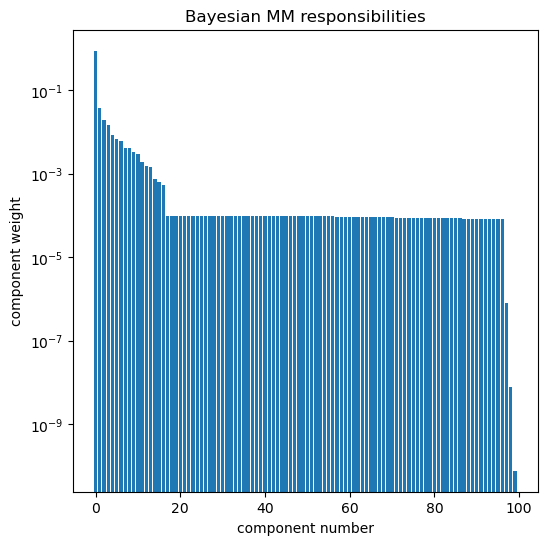

In [69]:
comp_number = [ x for x in range(N_RESPONSIBILITIES_MAX) ]
responsibilities = sorted(list(dpbgm.weights_),reverse=True)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(comp_number, responsibilities)
ax.set_xlabel('component number')
ax.set_ylabel('component weight')
ax.set_yscale("log")
ax.set_title(f'Bayesian MM responsibilities')
plt.show()

In [70]:
# get responsibilities per point
probas = dpbgm.predict_proba(df.to_numpy())

# get predicted label, and associated responsibility, per data point
labels = np.argmax(probas, axis=1)
certainty = np.max(probas, axis=1)

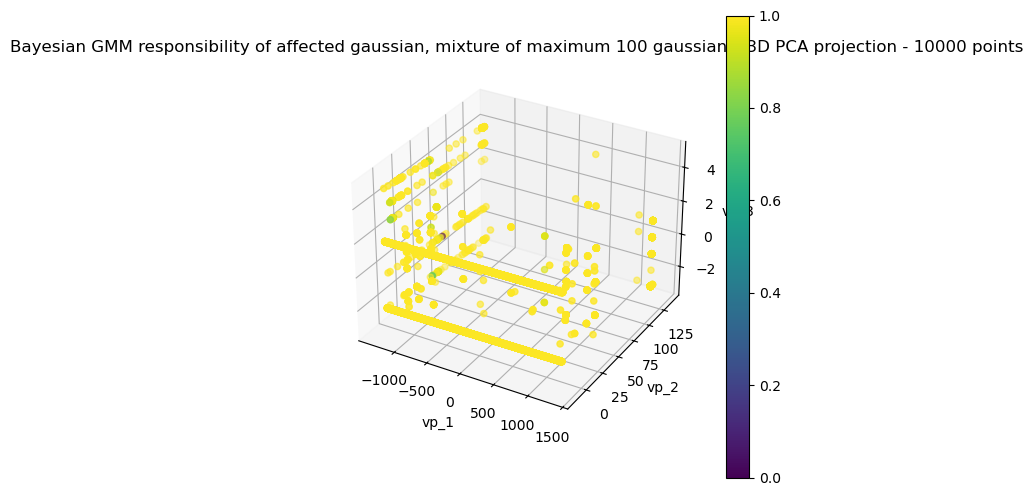

In [71]:
# 3D display of Bayesian GMM - projected points on PCA manifold

X_red = PCA(n_components=3).fit_transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(certainty)
vmax = np.max(certainty)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(certainty)), marker='o') # 
ax.set_title(f'Bayesian GMM responsibility of affected gaussian, \nmixture of maximum {N_RESPONSIBILITIES_MAX} gaussians, 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

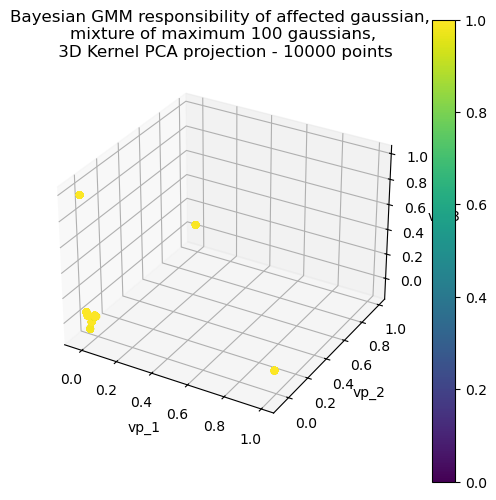

In [79]:
# 3D display of Bayesian GMM - projected points on Kernel-PCA manifold

X_red = KernelPCA(n_components=3, kernel='rbf', gamma=5.0).fit_transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(certainty)
vmax = np.max(certainty)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(certainty)), marker='o') # 
ax.set_title(f'Bayesian GMM responsibility of affected gaussian, \nmixture of maximum {N_RESPONSIBILITIES_MAX} gaussians,\n 3D Kernel PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()